In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


# Dades de les enquestes i dades generals dels treballadors
employee_data = pd.read_csv("./dataset/employee_survey_data.csv")
manager_data = pd.read_csv("./dataset/manager_survey_data.csv")
general_data = pd.read_csv("./dataset/general_data.csv")

# Temps d'entrada i sortida del treball de tot l'any de cada treballador
in_time = pd.read_csv("./dataset/in_time.csv")
out_time = pd.read_csv("./dataset/out_time.csv")

# 1. Preprocessat

In [17]:
# Calcular hora d'entrada i sortida mitjans per cada treballador
in_time = in_time.drop(in_time.columns[0], axis=1)
in_time = in_time.astype("datetime64[ns]")
in_time = in_time.applymap(lambda x: x.hour + x.minute/60 if not pd.isna(x.hour) else np.nan)

out_time = out_time.drop(out_time.columns[0], axis=1)
out_time = out_time.astype("datetime64[ns]")
out_time = out_time.applymap(lambda x: float(f"{x.hour}.{x.minute}") if not pd.isna(x.hour) else np.nan)

general_data["MeanInTime"] = in_time.mean(axis=1)
general_data["MeanOutTime"] = out_time.mean(axis=1)

In [18]:
# Agrupar dades
employee_data = employee_data.drop("EmployeeID", axis=1)
manager_data = manager_data.drop("EmployeeID", axis=1)
general_data = general_data.drop("EmployeeID", axis=1)
data = pd.concat([general_data, employee_data, manager_data], axis=1)
data

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1,0,0,9.993032,17.258621,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,...,5,1,4,9.980720,17.601229,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,...,5,0,3,10.016598,16.895289,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,...,8,7,5,9.973830,17.046383,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,...,6,0,4,9.990068,17.881796,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,Female,1,...,3,0,2,10.011317,18.396955,4.0,1.0,3.0,3,3
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,Male,1,...,3,0,2,9.996196,15.975436,4.0,4.0,3.0,2,3
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,Male,2,...,4,1,2,9.971501,17.548528,1.0,3.0,3.0,3,4
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,Male,1,...,9,7,8,10.010650,19.355021,4.0,1.0,3.0,2,3


In [19]:
# Informació dels tipus de columnes i quantitat de files no-nules per cadascuna
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  Over18                  

In [20]:
from sklearn.preprocessing import LabelEncoder

# Codificar dades categoriques (ignorarem els valors nuls al ser pocs)
labeled_cols = data.columns[data.dtypes == "object"]
col_encoders = {col: LabelEncoder() for col in labeled_cols}

data_encoded = data.copy()

for col, le in col_encoders.items():
    data_encoded[col] = le.fit_transform(data[col])

data_encoded.describe()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,36.923810,0.161224,1.607483,1.260544,9.192517,2.912925,2.247619,1.0,0.600000,2.063946,...,7.008163,2.187755,4.123129,9.991773,17.563634,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,0.367780,0.665304,0.527673,8.105026,1.023933,1.331067,0.0,0.489954,1.106689,...,6.125135,3.221699,3.567327,0.018147,1.339622,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,9.929079,15.761404,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.0,0.000000,1.000000,...,3.000000,0.000000,2.000000,9.979616,16.515815,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,0.000000,2.000000,1.000000,7.000000,3.000000,2.000000,1.0,1.000000,2.000000,...,5.000000,1.000000,3.000000,9.991957,17.278963,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,0.000000,2.000000,2.000000,14.000000,4.000000,3.000000,1.0,1.000000,3.000000,...,9.000000,3.000000,7.000000,10.003581,18.210203,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,1.000000,2.000000,2.000000,29.000000,5.000000,5.000000,1.0,1.000000,5.000000,...,40.000000,15.000000,17.000000,10.069684,20.958826,4.000000,4.000000,4.000000,4.000000,4.000000


In [21]:
# Borrem columnes sense variabilitat (std=0) que no ens interesen
not_interesting = data.columns[data_encoded.std() == 0]
data_encoded.drop(not_interesting, inplace=True, axis=1)
data.drop(not_interesting, inplace=True, axis=1)
not_interesting

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler

# Treiem valors nuls i normalitzem (amb estandarització z-score)
sc = StandardScaler()
data_encoded_nona = data_encoded.dropna()
X = data_encoded_nona.drop("Attrition", axis=1)
Xn = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
y = data_encoded_nona["Attrition"]

# 2. EDA

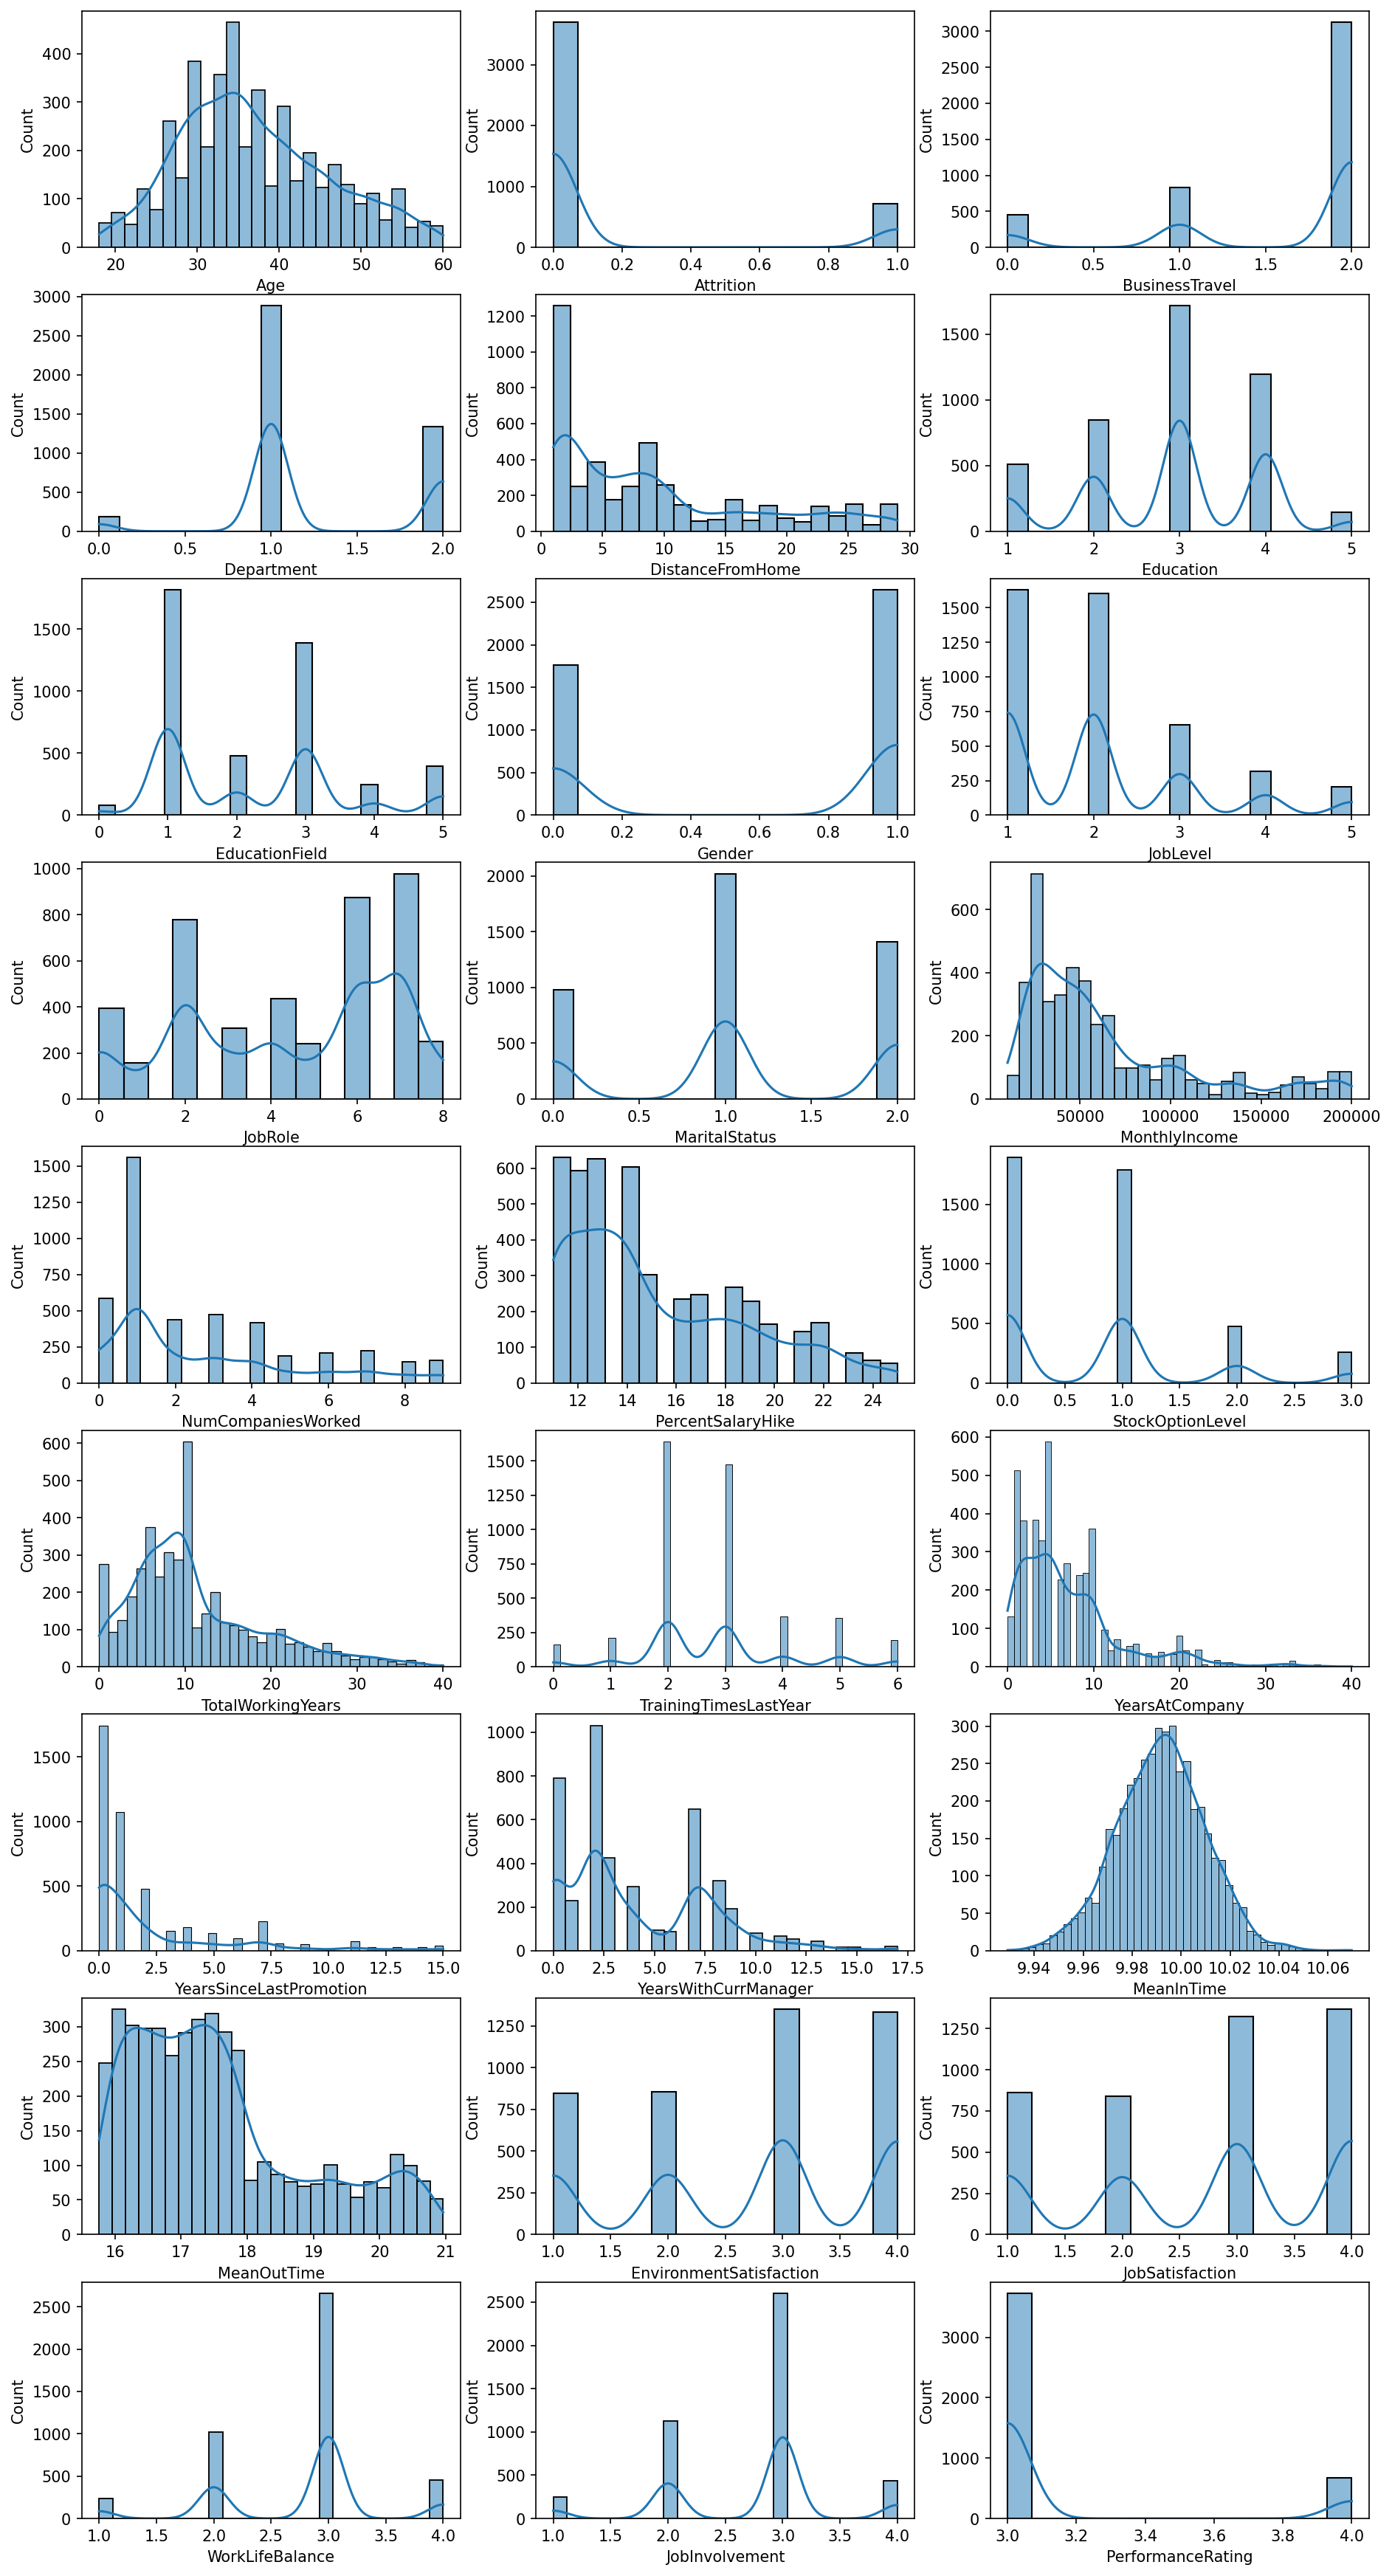

In [23]:
# Histogrames de les caracteristiques
def plot_hists(df, cols=None, hue=None, size=(15, 30), colwidth=3):
    fig, axs = plt.subplots(int(np.ceil(len(cols)/colwidth)), colwidth, figsize=size)
    for i, c in enumerate(cols):
        plt.subplot(int(np.ceil(len(cols)/colwidth)), colwidth, i+1)
        sns.histplot(df, x=c, kde=True, hue=hue, multiple="stack")

plot_hists(data_encoded, cols=data_encoded.columns)
plt.show()

,Attrition
No,0.838776
Yes,0.161224


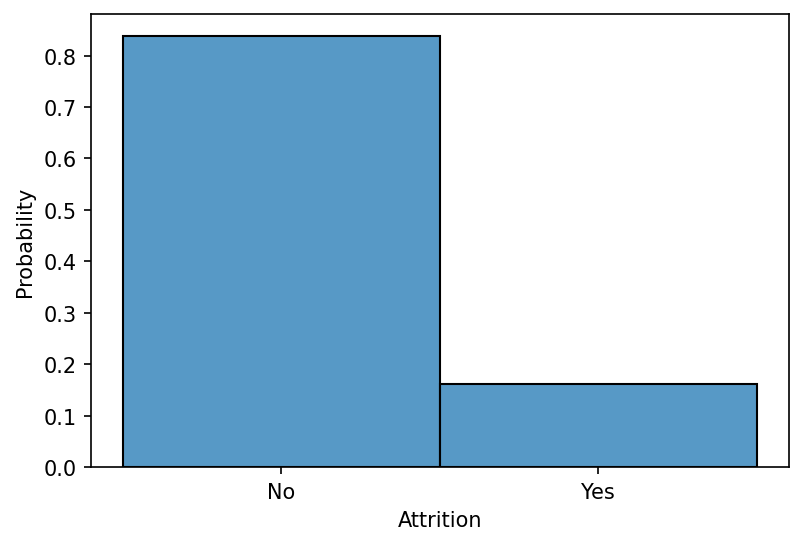

In [24]:
# Balanceig de les classes
sns.histplot(data["Attrition"], stat="probability")
data["Attrition"].value_counts(normalize=True).to_frame()

Com veiem tenim una distribució de les classes bastant desbalanceigada, per tant, caldrà tenir en compte quina mètrica utilitzem per avaluar els models, ja que sabem que per exemple l'accuracy pot donar una sensació falsa de bon rendiment del model en aquests casos de desbalanceig (i.e. un model que sempre predigui la classe majoritària tindrà més accuracy com més desbalanceig hi hagui, en aquest cas podria rondar el 80%).

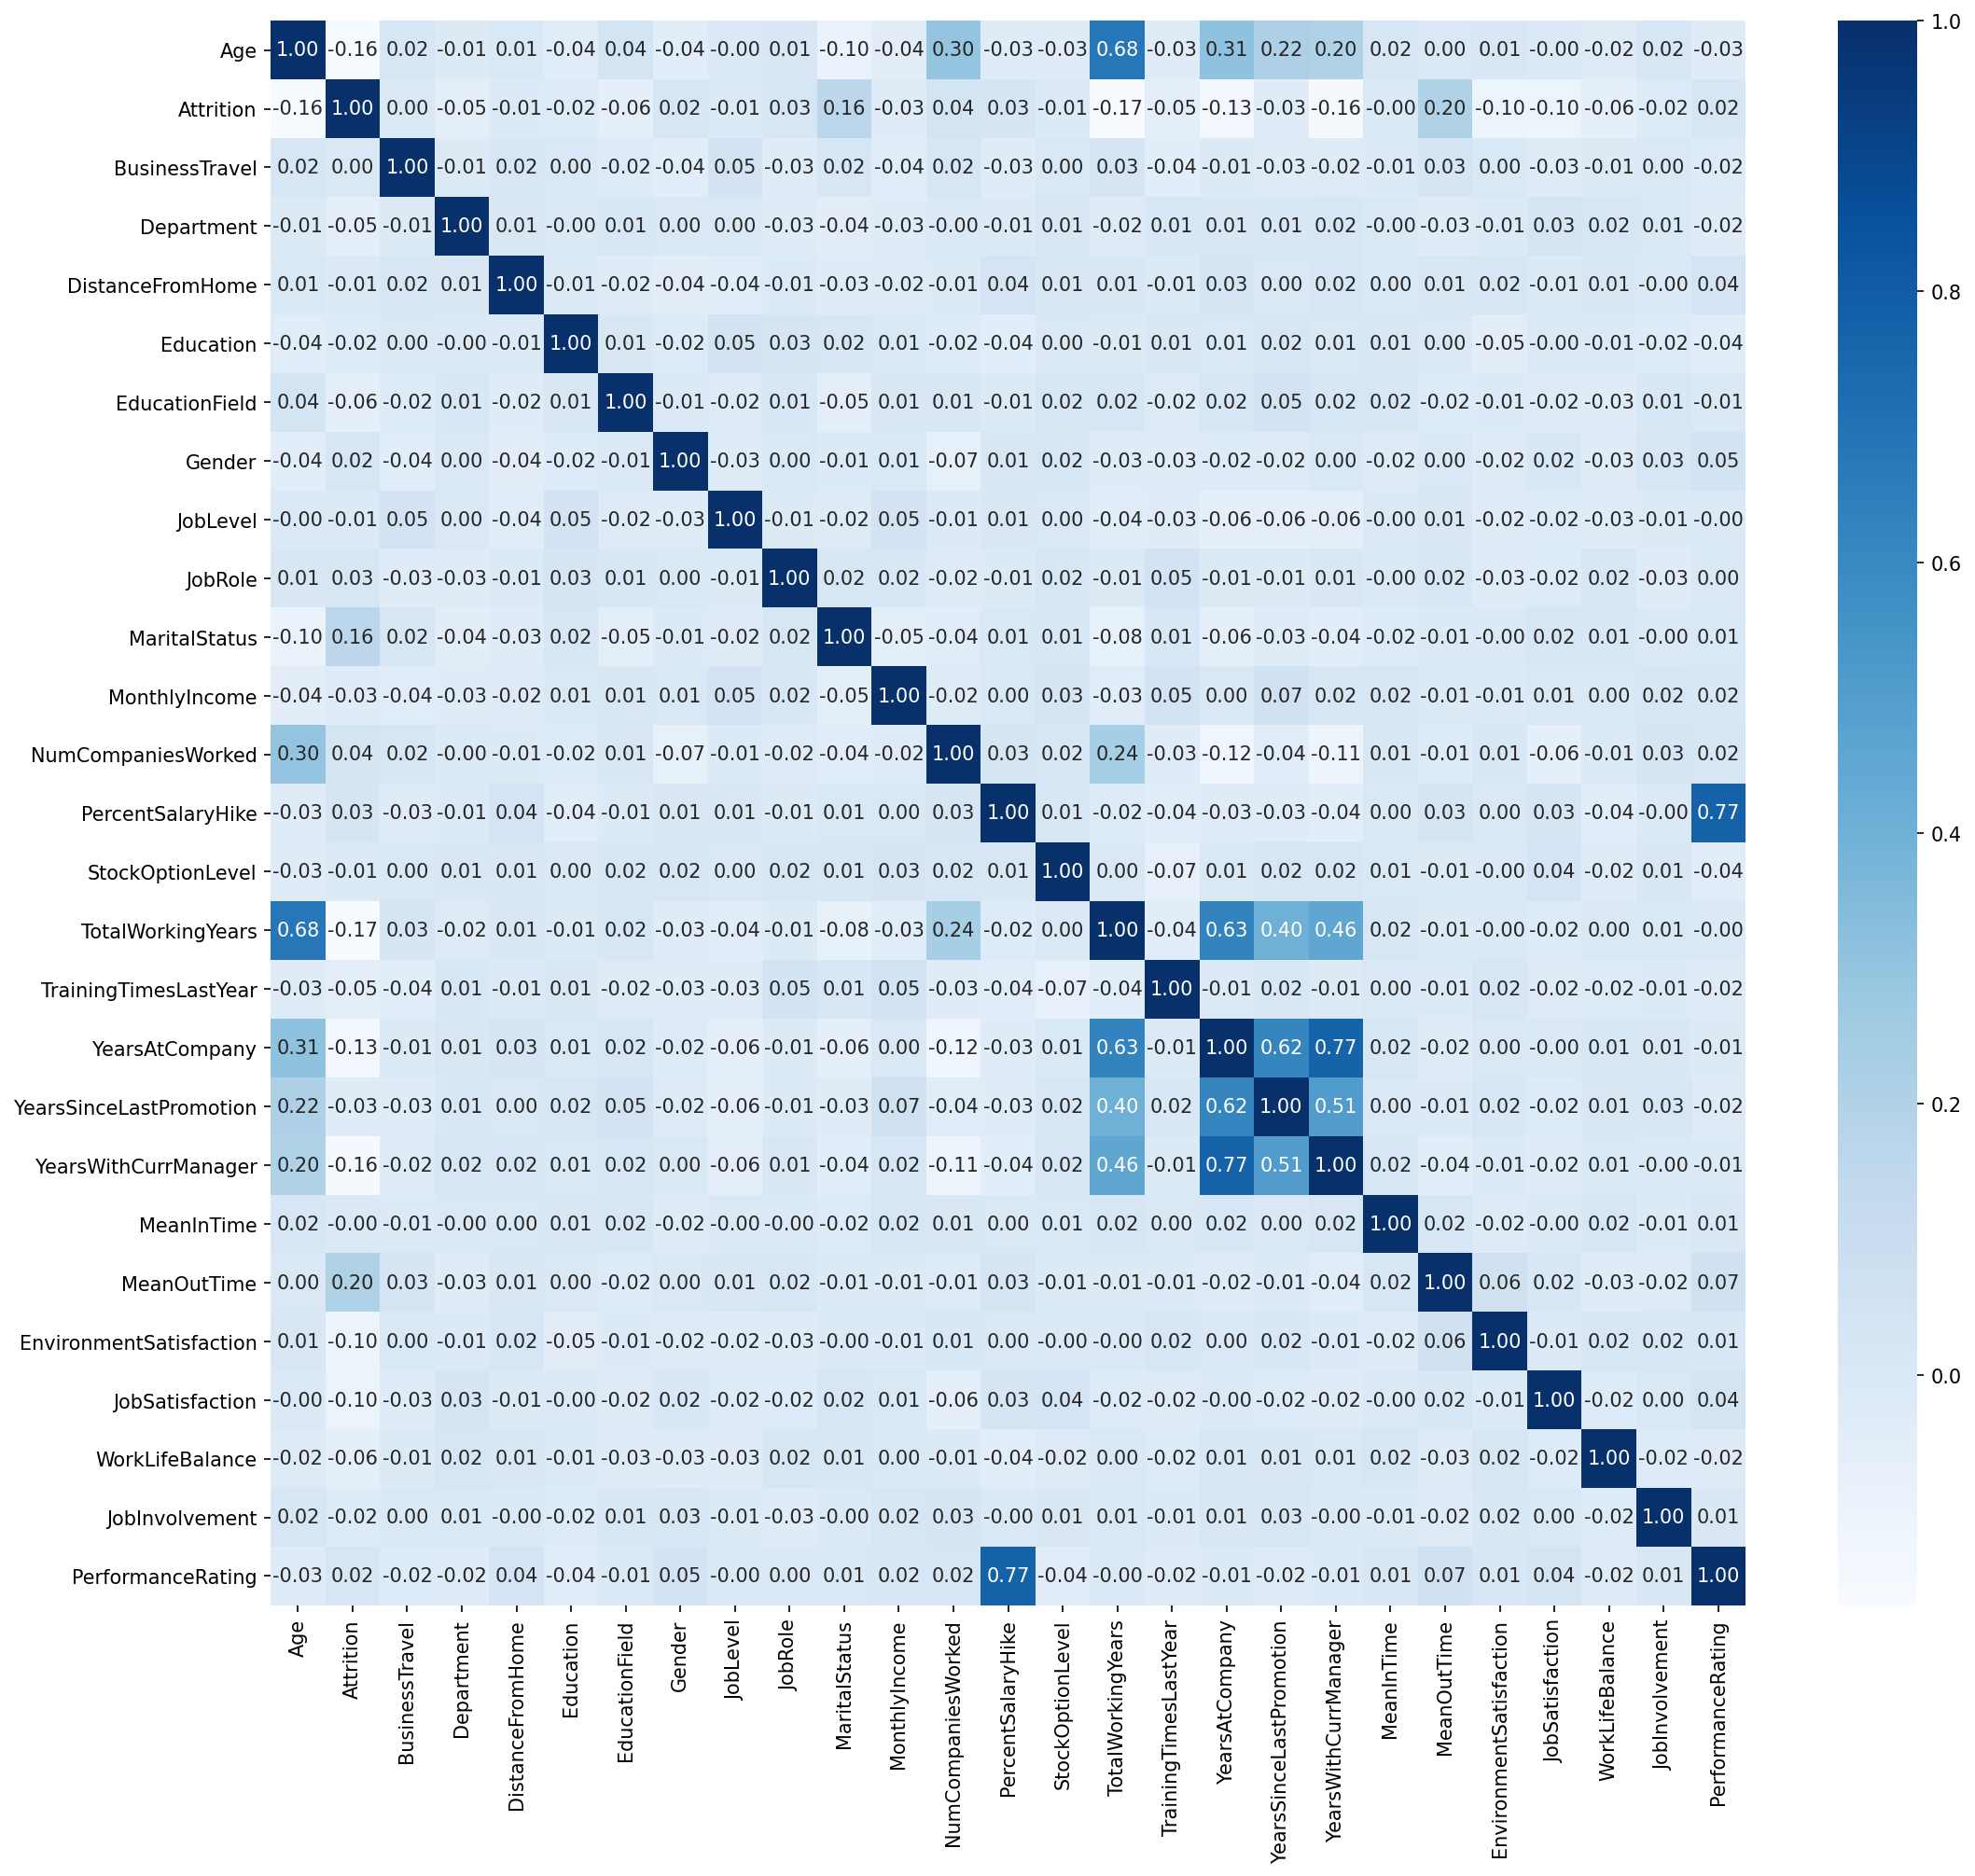

In [25]:
# Heatmap de correlació
plt.figure(figsize=(17,15))
corr = data_encoded.corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.show()

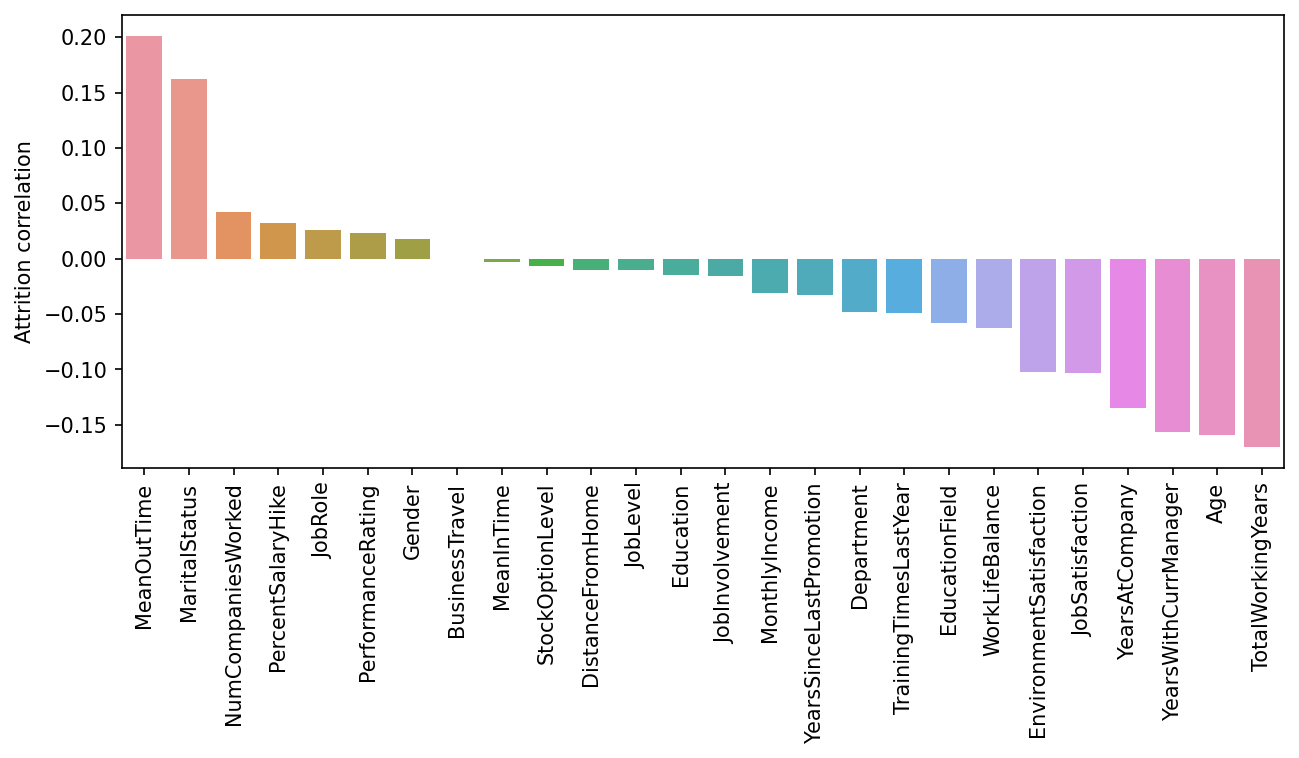

In [26]:
# Barplot de correlació de l'Attrition amb la resta
plt.figure(figsize=(10,4))
top_corr = corr["Attrition"].drop("Attrition").sort_values(ascending=False)
sns.barplot(x=top_corr.index, y=top_corr)
plt.ylabel("Attrition correlation")
plt.xticks(rotation=90)
plt.show()

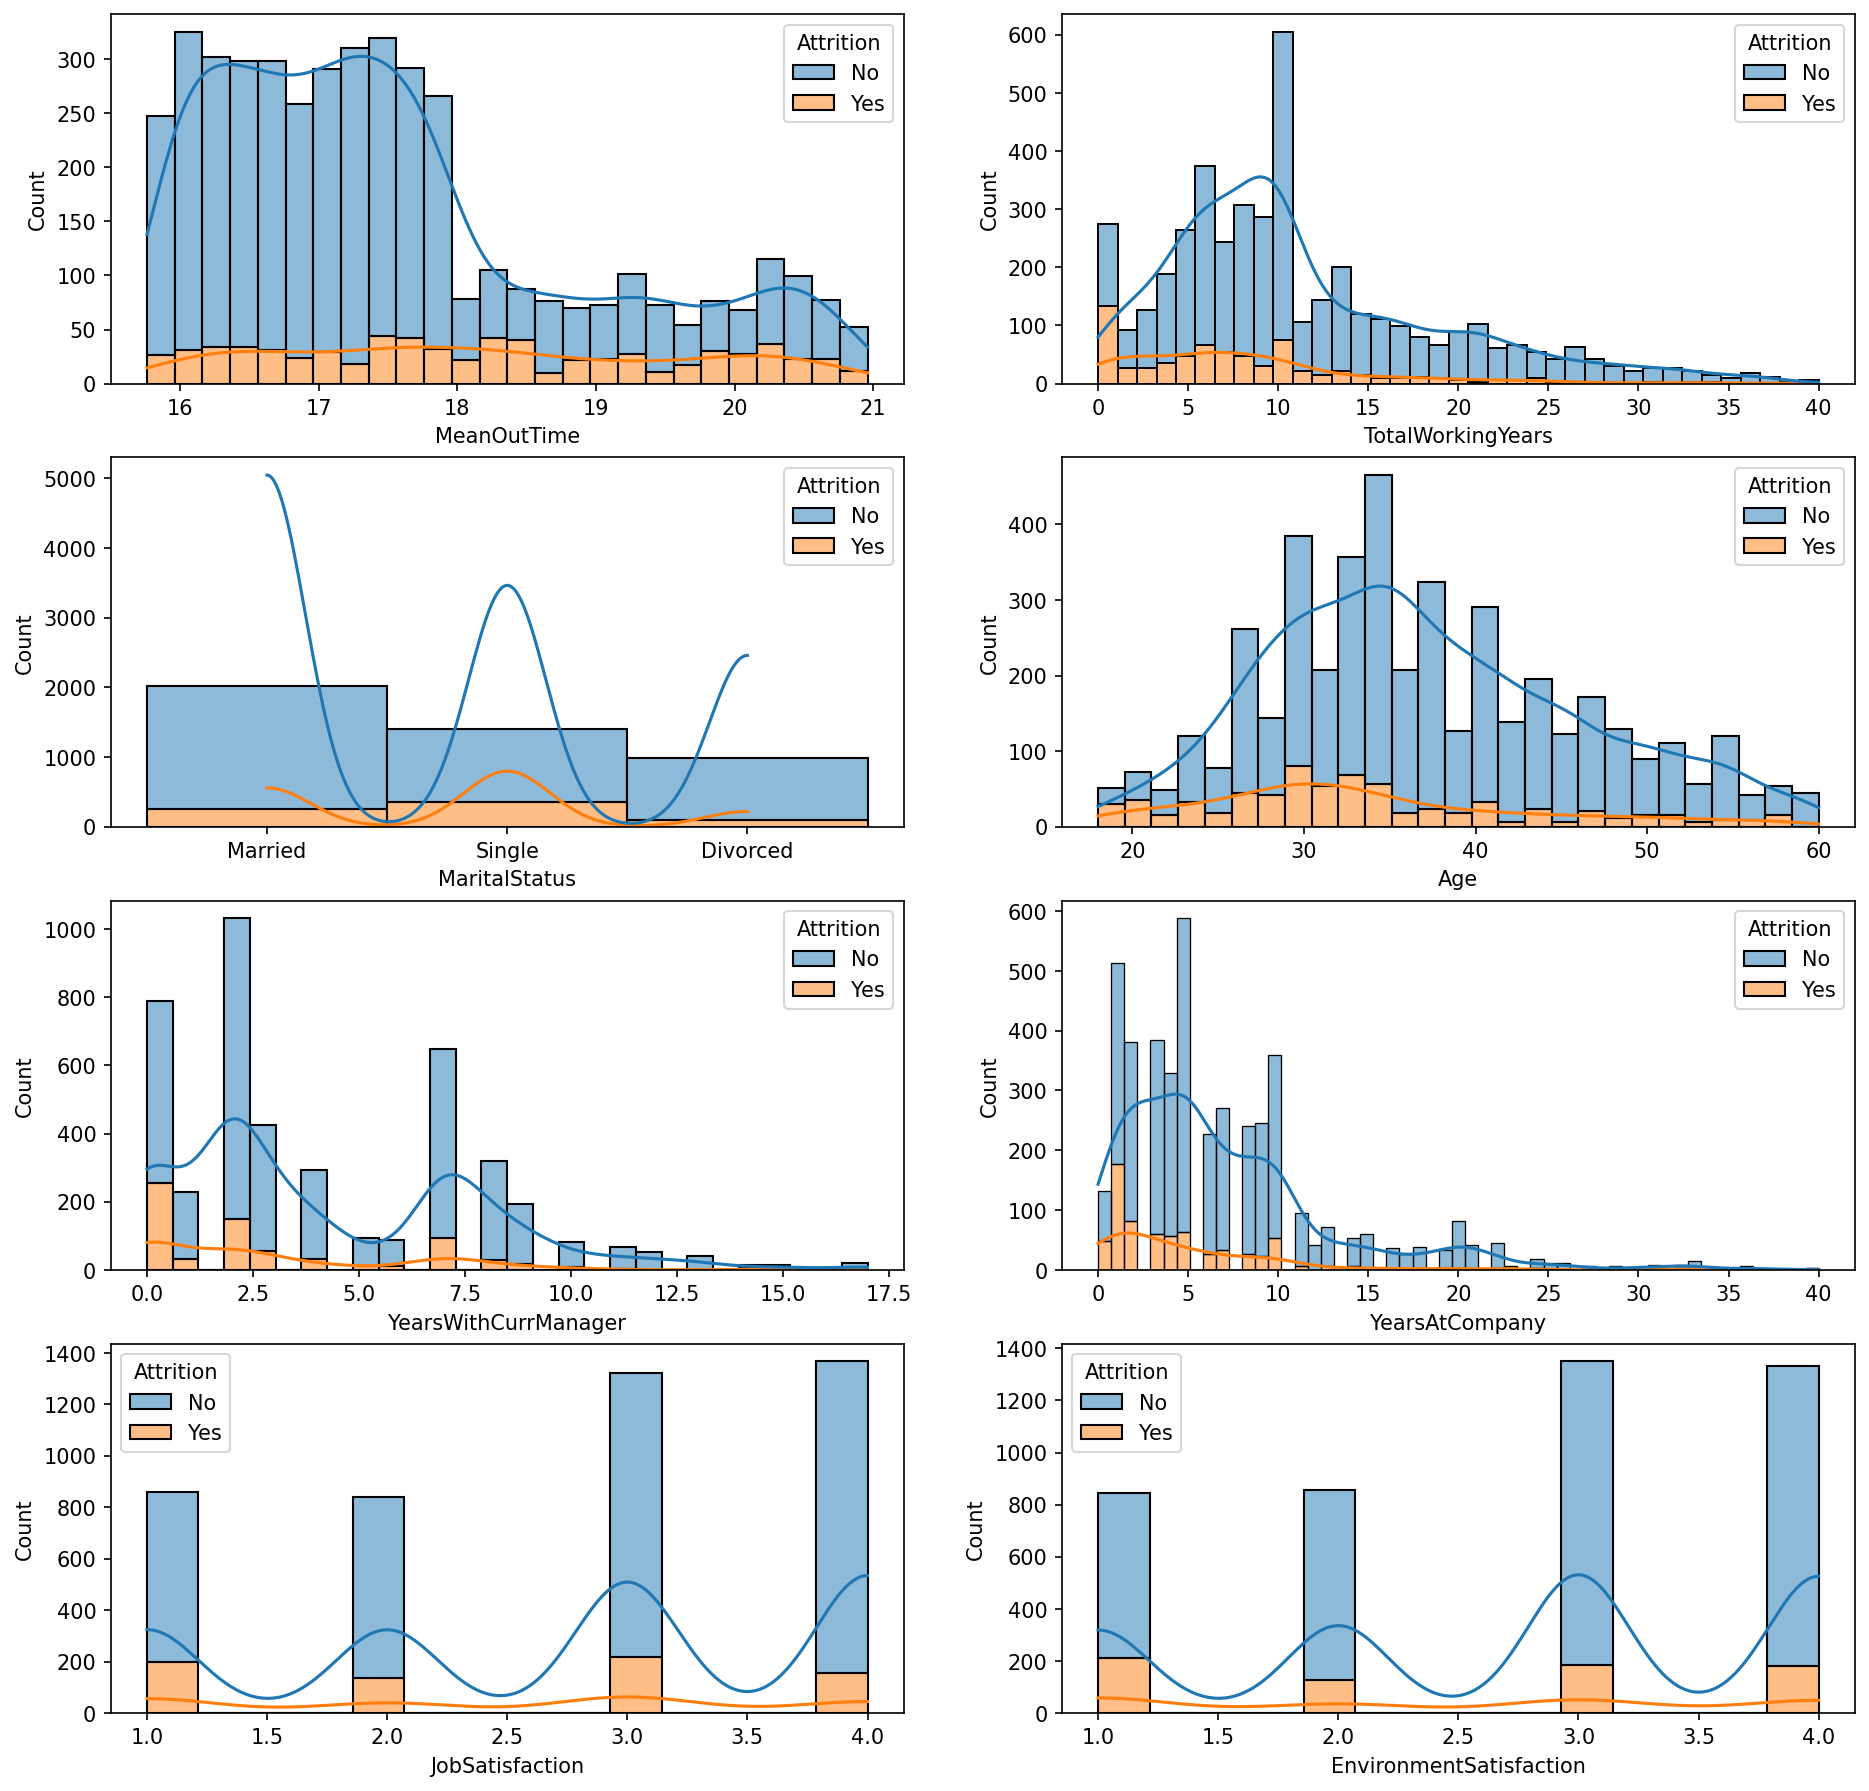

In [27]:
top8_abs_corr_cols = np.abs(top_corr).sort_values(ascending=False)[:8].index
plot_hists(data, cols=top8_abs_corr_cols, hue="Attrition", size=(15,15), colwidth=2)
plt.show()

Per les dades veiem que el perfil tendent (encara que de forma lleu) a anar-se'n de l'empresa és gent que surt tard del treball, està soltera, és jove (<40 anys), no té un manager estable, i no té molta experiència acumulada ni en la seva vida laboral ni en l'empresa. Addicionalment, aquestes persones també notifiquen dades més negatives quant a la satisfacció del treball i de l'entorn.


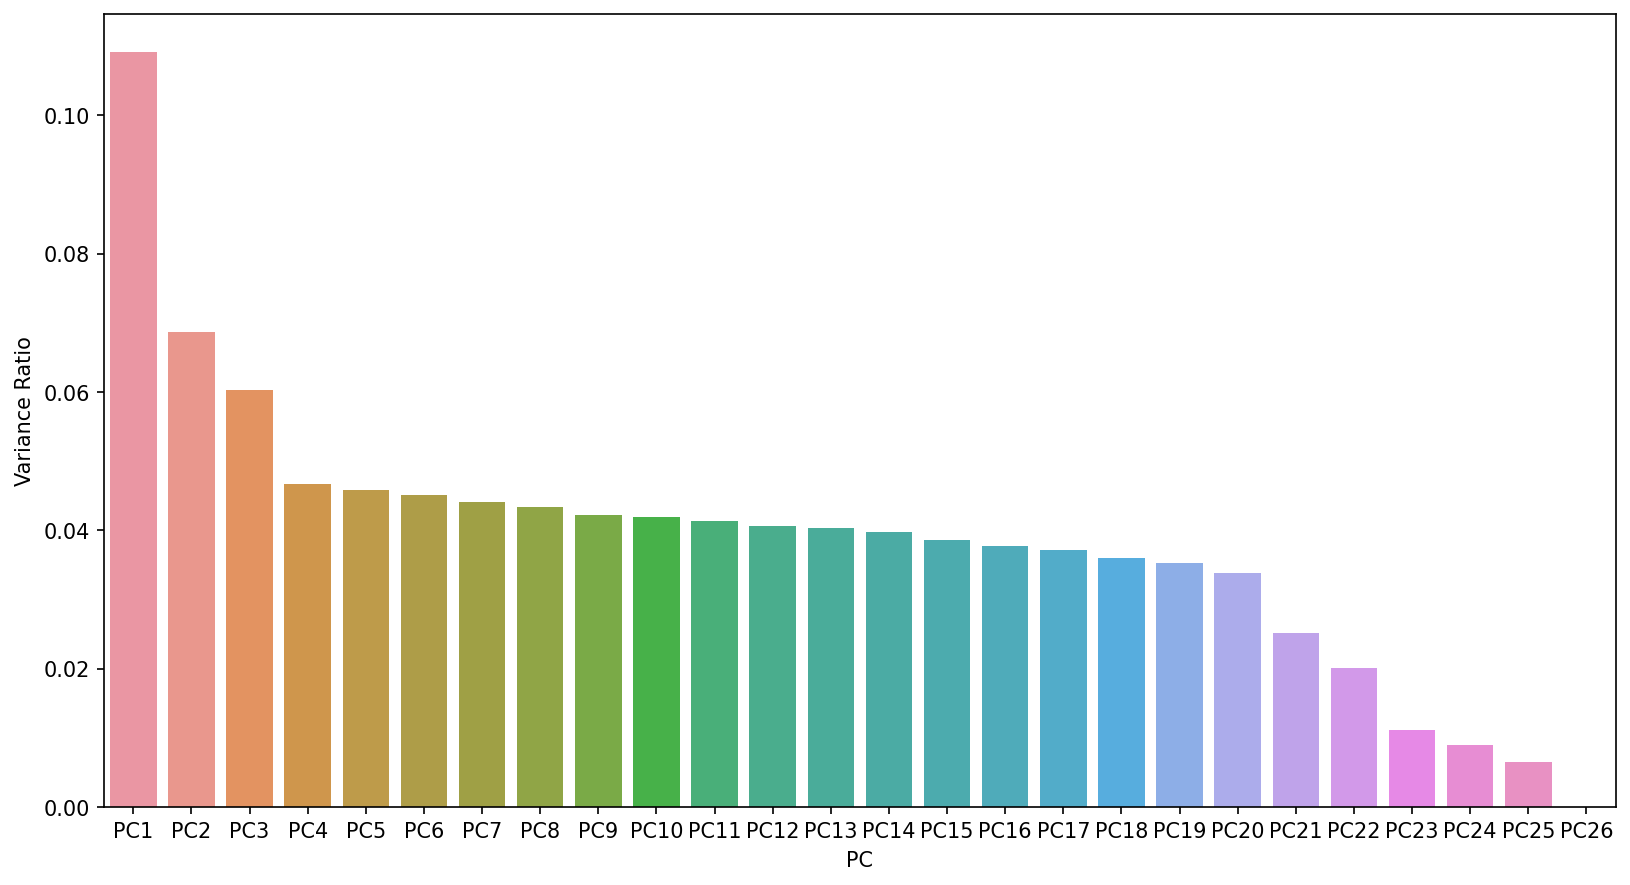

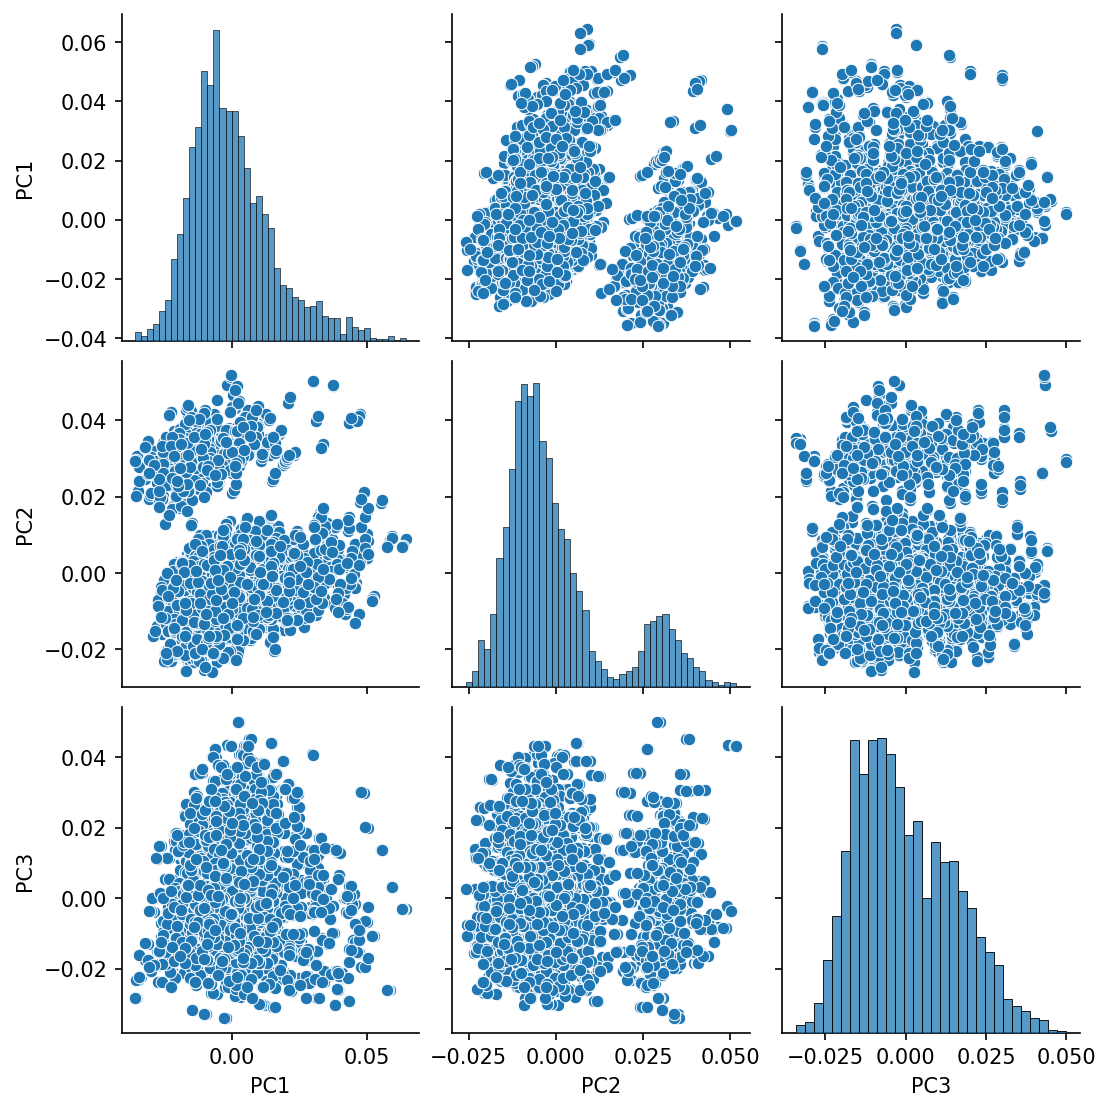

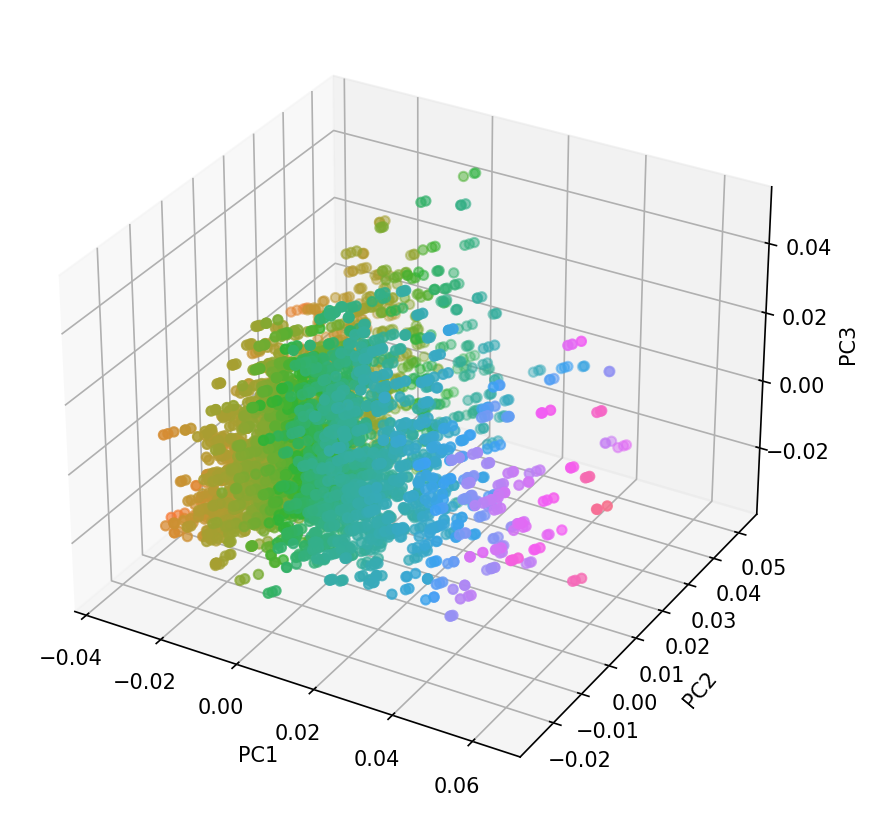

In [28]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA().fit(Xn.to_numpy().T)
pca_df = pd.DataFrame({f"PC{i+1}" : pca.components_[i] for i in range(len(pca.components_))})

pca_vr = pd.DataFrame({"PC" : pca_df.columns, "Variance Ratio": pca.explained_variance_ratio_})

# Barplot amb el ratio d'implicació a la variancia dels PC
plt.figure(figsize=(13,7))
sns.barplot(data=pca_vr, x="PC", y="Variance Ratio")

# Scatterplots 2D de PCA1, PCA2 i PCA3
v = ["PC1", "PC2", "PC3"]
sns.pairplot(data=pca_df, vars=v)
plt.show()

# Scatterplot 3D de PCA1, PCA2 i PCA3
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection="3d")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
ax.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=pca_df["PC1"], cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2", rotation=50)
ax.set_zlabel("PC3", rotation=90)
plt.show()

L'analisis PCA dona uns components amb poc ratio d'implicació a la variança (menor al 10%), i per tant no s'utilitza.

# 3. Evaluació i selecció de models

LogisticRegression()
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1083
           1       0.65      0.22      0.33       207

    accuracy                           0.86      1290
   macro avg       0.76      0.60      0.62      1290
weighted avg       0.83      0.86      0.82      1290



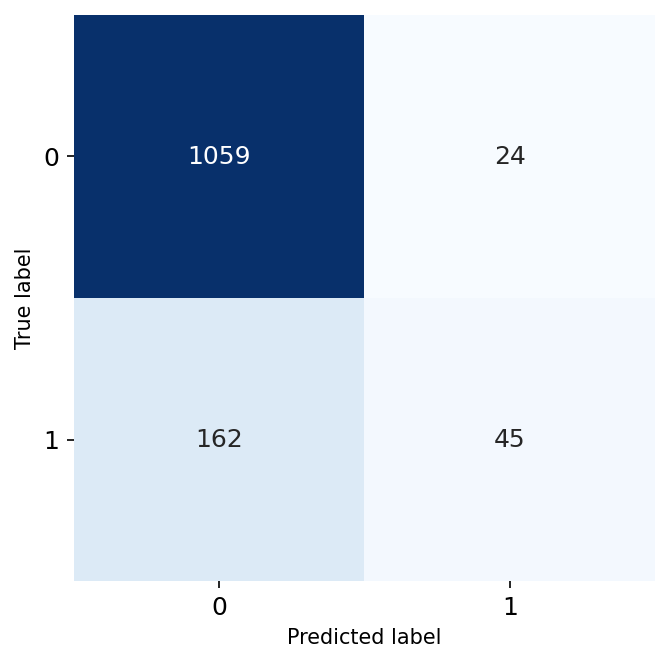

SVC()
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1083
           1       0.83      0.45      0.59       207

    accuracy                           0.90      1290
   macro avg       0.87      0.72      0.76      1290
weighted avg       0.89      0.90      0.88      1290



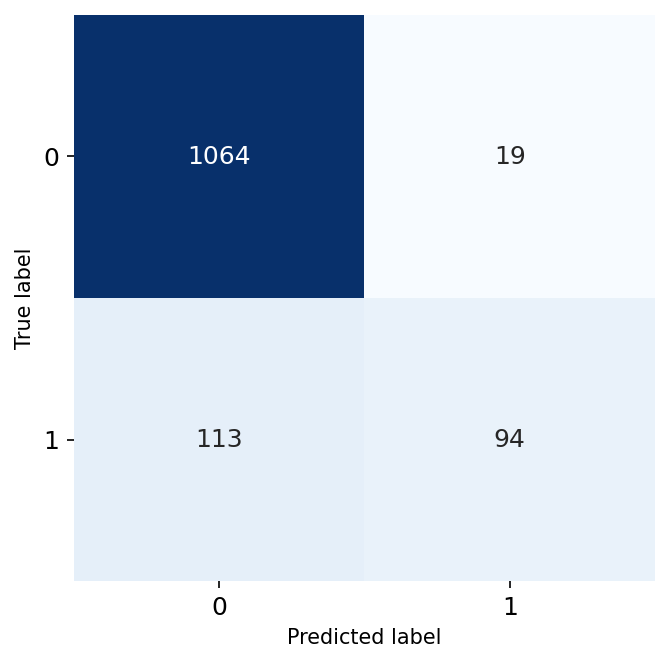

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1083
           1       0.98      0.90      0.94       207

    accuracy                           0.98      1290
   macro avg       0.98      0.95      0.96      1290
weighted avg       0.98      0.98      0.98      1290



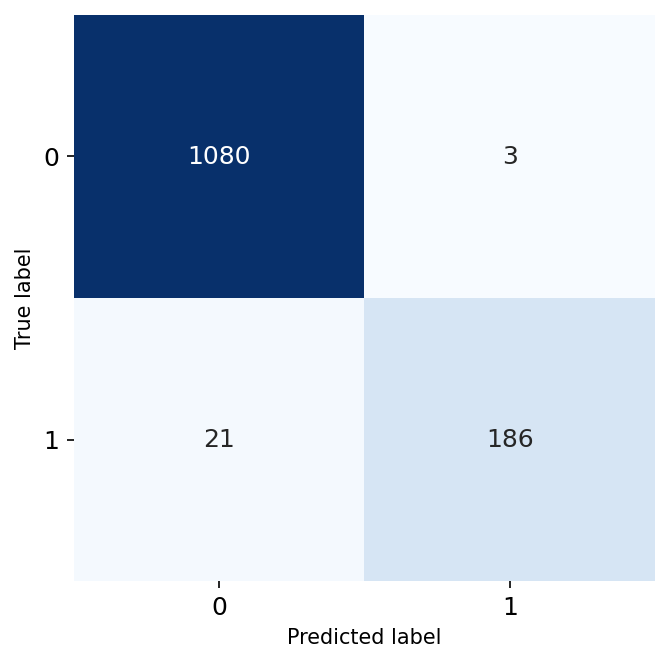

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1083
           1       0.54      0.29      0.38       207

    accuracy                           0.85      1290
   macro avg       0.71      0.62      0.65      1290
weighted avg       0.82      0.85      0.83      1290



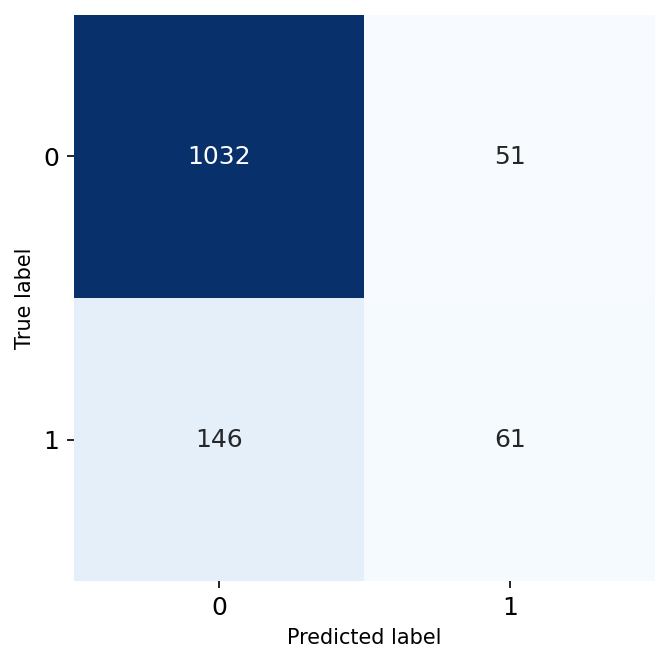

GaussianNB()
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1083
           1       0.40      0.40      0.40       207

    accuracy                           0.81      1290
   macro avg       0.64      0.64      0.64      1290
weighted avg       0.81      0.81      0.81      1290



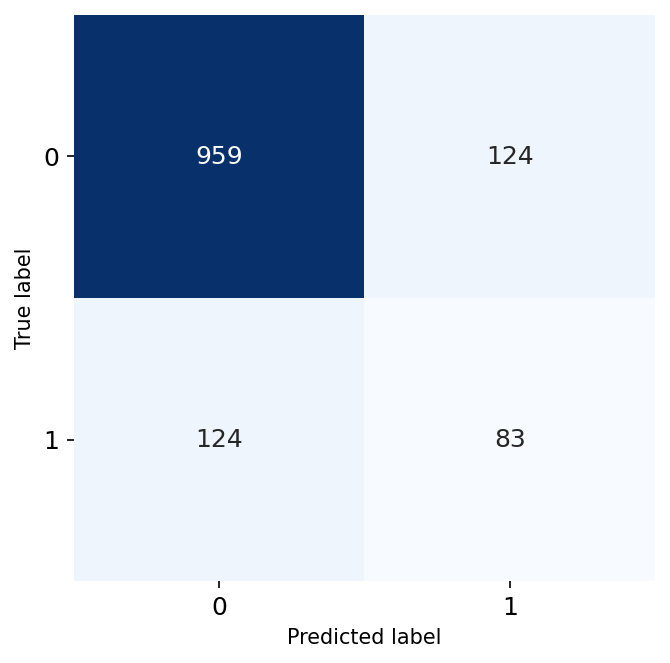

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".0f", cbar=False, annot_kws={"size": 12})
    plt.xlabel("Predicted label")
    plt.xticks(size=12, rotation=0)
    plt.ylabel("True label")
    plt.yticks(size=12, rotation=0)
    plt.show()
    

# Generar un baseline pels diferents models escollits

state = 44203
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=.3, random_state=state)

models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GaussianNB()
]

for model in models:
    print(model)
    #model = RandomForestClassifier(random_state=state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_cm(y_test, y_pred)

In [30]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Buscar els millors parametres pel classificador basat en Random Forests amb elecció
# de f1 com a métrica de scoring en la seva versió macro per comptar totes les classes per igual

params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]
}

grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=state),
    cv=StratifiedKFold(n_splits=5),
    param_distributions=params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=state
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print(best_rf)
print(f"Best RF macro-f1 score: {grid.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=1000,
                       random_state=44203)
Best RF macro-f1 score: 0.9348


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1083
           1       0.97      0.94      0.95       207

    accuracy                           0.99      1290
   macro avg       0.98      0.97      0.97      1290
weighted avg       0.99      0.99      0.99      1290



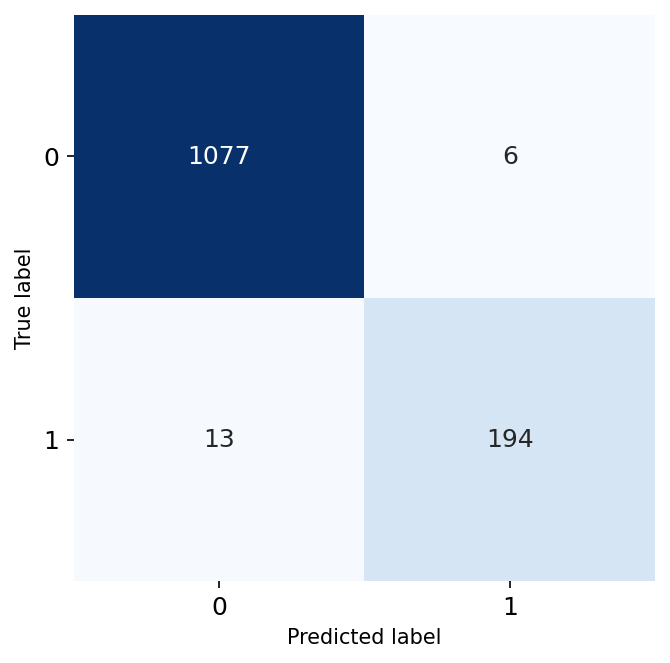

In [31]:
# Test de classificació amb el millor model trobat

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred)

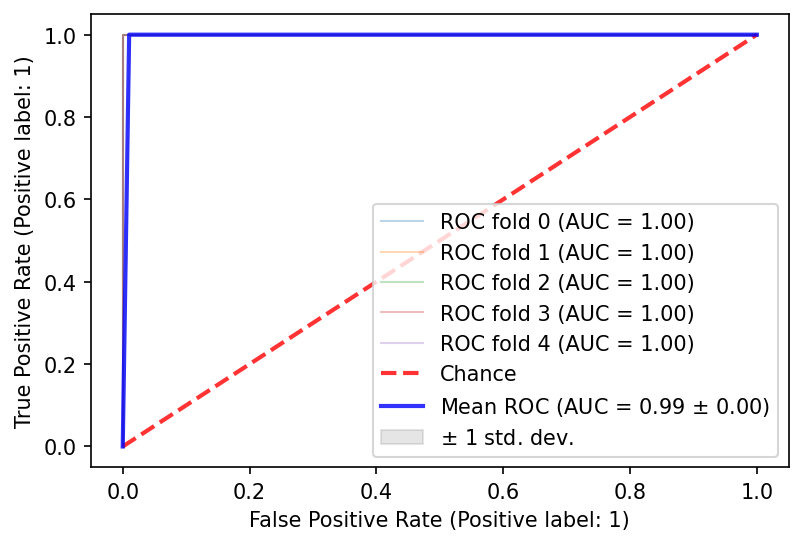

In [32]:
from sklearn.metrics import auc, plot_roc_curve

# Curva ROC amb validació creuada (stratificada) (k=5) del millor model de RF

cv = StratifiedKFold(n_splits=5)
classifier = best_rf

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(Xn, y)):
    classifier.fit(Xn.iloc[train], y.iloc[train])
    viz = plot_roc_curve(classifier, Xn.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")

plt.show()